# Isolation Forest - Two Best Approaches Comparison

This notebook compares the two best approaches for training Isolation Forest on the Elliptic dataset:

1. **All Labeled Data** - Train on licit + illicit (exclude unknown)
2. **All Data** - Train on licit + illicit + unknown (complete dataset)

We'll evaluate both on labeled test data and see which performs better.

In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import umap

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)

## 1. Load and Analyze Data

In [268]:
# Load the transactions dataset
transactions_df = pd.read_csv("../02_data/transactions.csv")

print(f"Dataset shape: {transactions_df.shape}")
print(f"\nFirst few rows:")
transactions_df.head()

Dataset shape: (203769, 168)

First few rows:


,txId,class,timeStep,local1,local2,local3,local4,local5,local6,local7,local8,local9,local10,local11,local12,local13,local14,local15,local16,local17,local18,local19,local20,local21,local22,local23,local24,local25,local26,local27,local28,local29,local30,local31,local32,local33,local34,local35,local36,local37,local38,local39,local40,local41,local42,local43,local44,local45,local46,local47,local48,local49,local50,local51,local52,local53,local54,local55,local56,local57,local58,local59,local60,local61,local62,local63,local64,local65,local66,local67,local68,local69,local70,local71,local72,local73,local74,local75,local76,local77,local78,local79,local80,local81,local82,local83,local84,local85,local86,local87,local88,local89,local90,local91,local92,local93,aggregate1,aggregate2,aggregate3,aggregate4,aggregate5,aggregate6,aggregate7,aggregate8,aggregate9,aggregate10,aggregate11,aggregate12,aggregate13,aggregate14,aggregate15,aggregate16,aggregate17,aggregate18,aggregate19,aggregate20,aggregate21,aggregate22,aggregate23,aggregate24,aggregate25,aggregate26,aggregate27,aggregate28,aggregate29,aggregate30,aggregate31,aggregate32,aggregate33,aggregate34,aggregate35,aggregate36,aggregate37,aggregate38,aggregate39,aggregate40,aggregate41,aggregate42,aggregate43,aggregate44,aggregate45,aggregate46,aggregate47,aggregate48,aggregate49,aggregate50,aggregate51,aggregate52,aggregate53,aggregate54,aggregate55,aggregate56,aggregate57,aggregate58,aggregate59,aggregate60,aggregate61,aggregate62,aggregate63,aggregate64,aggregate65,aggregate66,aggregate67,aggregate68,aggregate69,aggregate70,aggregate71,aggregate72
0,230425980,unknown,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,-0.167933,-0.049707,-0.164402,-0.028741,-0.035391,-0.042955,-0.013282,-0.057195,-0.169609,-0.171154,-0.174473,-1.373657,-1.371460,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,-0.239368,-0.075256,-0.234952,0.037468,0.043444,-0.227203,-0.243236,-0.097895,-0.235896,0.036577,0.042345,-0.414005,-0.488340,-0.232553,-0.467554,0.048767,0.052956,-0.039149,-0.172895,-0.163126,-0.160932,-1.316342,-1.315388,-0.039144,-0.172884,-0.163115,-0.160925,-1.316333,-1.315375,-0.017032,-0.030026,-0.017640,-0.015071,-0.140763,-0.140335,-0.095403,-0.264376,-0.250523,-0.263703,1.133527,1.135947,-0.059013,-0.262368,-0.255111,-0.259194,1.125590,1.128038,-0.293773,-0.159732,0.034039,-0.183816,1.135523,1.135279,-0.169160,-0.201584,-0.116817,-0.191472,-0.014659,-0.018849,-1.457953,-1.494057,-0.083459,-1.485972,-0.088798,-0.090437,-0.166550,-0.216536,-0.134546,-0.194817,-0.003175,-0.004094,-1.096336,-1.267340,-0.349933,-1.230441,-0.004358,-0.004194,-0.116425,-0.176617,-0.137323,-0.152464,-0.026060,-0.027660,-0.093145,-0.143707,-0.097719,-0.127462,0.003143,0.002426,-0.120950,-0.199145,-0.187993,-0.212948,1.064205,1.063787,-1.373782,-1.354735,-0.297975,-1.403698,1.342003,1.340733,-0.171601,-0.458162,-0.423588,-0.440883,-1.015963,-1.016230,-0.968903,-0.375715,0.759748,-0.768329,1.488113,1.487932,-0.216814,-0.605631,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,unknown,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,-0.239368,-0.075256,-0.234952,0.037468,0.043444,-0.227203,-0.243236,-0.097895,-0.235896,0.036577,0.042345,-0.413965,-0.488307,-0.232553,-0.467516,0.048767,0.052956,-0.039151,-0.172895,-0.163126,-0.160933,0.923473,0.923011,-0.039146,-0.172884,-0.163114,-0.160926,0.923516,0.923110,-0.017032,-0.030026,-0.017640,-0.015071,-0.14076

In [269]:
# Separate features and labels
X = transactions_df.drop(columns=["class"])
y = transactions_df["class"]

# Analyze class distribution
print("Class Distribution:")
print("="*50)
print(y.value_counts())
print("\nPercentages:")
print(y.value_counts(normalize=True) * 100)

# Calculate statistics
total = len(y)
licit_count = (y == 'licit').sum()
illicit_count = (y == 'illicit').sum()
unknown_count = (y == 'unknown').sum()

print(f"\nDataset Composition:")
print(f"  Licit: {licit_count:,} ({licit_count/total*100:.2f}%)")
print(f"  Illicit: {illicit_count:,} ({illicit_count/total*100:.2f}%)")
print(f"  Unknown: {unknown_count:,} ({unknown_count/total*100:.2f}%)")

Class Distribution:
class
unknown    157205
licit       42019
illicit      4545
Name: count, dtype: int64

Percentages:
class
unknown    77.148634
licit      20.620899
illicit     2.230467
Name: proportion, dtype: float64

Dataset Composition:
  Licit: 42,019 (20.62%)
  Illicit: 4,545 (2.23%)
  Unknown: 157,205 (77.15%)


## 2. Train/Test Split and Scaling

In [270]:
# Train/Test split: 75/25 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData scaled using StandardScaler")

Training set: (152826, 167)
Test set: (50943, 167)

Data scaled using StandardScaler


## 3. Approach 1: Train on ALL LABELED Data (licit + illicit)

This approach trains only on labeled transactions, excluding unknowns.

In [271]:
# Filter to labeled data only (exclude unknown)
labeled_mask_train = y_train.isin(['licit', 'illicit'])
X_train_labeled = X_train_scaled[labeled_mask_train]
y_train_labeled = y_train[labeled_mask_train]

# Calculate contamination from labeled data
illicit_rate_labeled = (y_train_labeled == 'illicit').sum() / len(y_train_labeled)

print("Training Data for Approach 1:")
print("="*50)
print(f"  Total: {len(X_train_labeled):,}")
print(f"  Licit: {(y_train_labeled == 'licit').sum():,} ({(y_train_labeled == 'licit').sum()/len(X_train_labeled)})")
print(f"  Illicit: {(y_train_labeled == 'illicit').sum():,} ({(y_train_labeled == 'illicit').sum()/len(X_train_labeled)})")
print(f"  Contamination rate: {illicit_rate_labeled:.4f} ({illicit_rate_labeled*100:.2f}%)")

# Train Isolation Forest
iso_forest_labeled = IsolationForest(
    contamination=illicit_rate_labeled * 2,  # Use actual rate with buffer
    # contamination=.25,
    max_samples=256,
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

print(f"Contamination Rate Used For Model: {illicit_rate_labeled * 2} ")

print("\nTraining Isolation Forest...")
iso_forest_labeled.fit(X_train_labeled)
print("✓ Training complete!")

Training Data for Approach 1:
  Total: 34,923
  Licit: 31,514 (0.9023852475445981)
  Illicit: 3,409 (0.09761475245540188)
  Contamination rate: 0.0976 (9.76%)
Contamination Rate Used For Model: 0.19522950491080376 

Training Isolation Forest...
✓ Training complete!


In [272]:
# Predict on test set (IMPORTANT: use scaled data!)
y_pred_labeled = iso_forest_labeled.predict(X_test_scaled)
scores_labeled = iso_forest_labeled.decision_function(X_test_scaled)

print("Test Set Predictions:")
print("="*50)
print(f"  Normal: {(y_pred_labeled == 1).sum():,} ({(y_pred_labeled == 1).sum()/len(y_pred_labeled)*100:.1f}%)")
print(f"  Anomalies: {(y_pred_labeled == -1).sum():,} ({(y_pred_labeled == -1).sum()/len(y_pred_labeled)*100:.1f}%)")

Test Set Predictions:
  Normal: 47,332 (92.9%)
  Anomalies: 3,611 (7.1%)


## 4. Approach 2: Train on ALL DATA (licit + illicit + unknown)

This approach uses the complete training set, including unknown transactions.

In [273]:
# Use ALL training data
X_train_all = X_train_scaled
y_train_all = y_train

# Calculate contamination (based on illicit only, not unknown)
illicit_rate_all = (y_train_all == 'illicit').sum() / len(y_train_all)

print("Training Data for Approach 2:")
print("="*50)
print(f"  Total: {len(X_train_all):,}")
print(f"  Licit: {(y_train_all == 'licit').sum():,}")
print(f"  Illicit: {(y_train_all == 'illicit').sum():,}")
print(f"  Unknown: {(y_train_all == 'unknown').sum():,}")
print(f"  Contamination rate (illicit): {illicit_rate_all:.4f} ({illicit_rate_all*100:.2f}%)")

# Train Isolation Forest
iso_forest_all = IsolationForest(
    contamination=illicit_rate_all * 2,  # Slightly higher buffer
    # contamination=.25,
    max_samples=256,
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

print(f"Contaimination Rate Used For Model: {illicit_rate_all * 2} ")

print("\nTraining Isolation Forest...")
iso_forest_all.fit(X_train_all)
print("✓ Training complete!")

print(f"\n📊 Training sample difference: {len(X_train_all) - len(X_train_labeled):,} more samples than Approach 1")

Training Data for Approach 2:
  Total: 152,826
  Licit: 31,514
  Illicit: 3,409
  Unknown: 117,903
  Contamination rate (illicit): 0.0223 (2.23%)
Contaimination Rate Used For Model: 0.044612827660214883 

Training Isolation Forest...
✓ Training complete!

📊 Training sample difference: 117,903 more samples than Approach 1


In [274]:
# Predict on test set
y_pred_all = iso_forest_all.predict(X_test_scaled)
scores_all = iso_forest_all.decision_function(X_test_scaled)

print("Test Set Predictions:")
print("="*50)
print(f"  Normal: {(y_pred_all == 1).sum():,} ({(y_pred_all == 1).sum()/len(y_pred_all)*100:.1f}%)")
print(f"  Anomalies: {(y_pred_all == -1).sum():,} ({(y_pred_all == -1).sum()/len(y_pred_all)*100:.1f}%)")

Test Set Predictions:
  Normal: 48,672 (95.5%)
  Anomalies: 2,271 (4.5%)


## 5. Evaluation on Labeled Test Data

We evaluate both approaches on labeled test data (licit + illicit) for fair comparison.

In [275]:
# Filter test data to labeled only
labeled_mask_test = y_test.isin(['licit', 'illicit'])
y_test_labeled = y_test[labeled_mask_test]

print(f"Evaluating on {labeled_mask_test.sum():,} labeled test transactions:")
print(f"  Licit: {(y_test_labeled == 'licit').sum():,} ({(y_test_labeled == 'licit').sum()/labeled_mask_test.sum()})")
print(f"  Illicit: {(y_test_labeled == 'illicit').sum():,} ({(y_test_labeled == 'illicit').sum()/labeled_mask_test.sum()})")

# Convert predictions to labels
def convert_predictions(y_pred, mask):
    y_pred_masked = y_pred[mask]
    return np.where(y_pred_masked == -1, 'illicit', 'licit')

y_pred_labeled_conv = convert_predictions(y_pred_labeled, labeled_mask_test)
y_pred_all_conv = convert_predictions(y_pred_all, labeled_mask_test)

Evaluating on 11,641 labeled test transactions:
  Licit: 10,505 (0.902413881968903)
  Illicit: 1,136 (0.09758611803109699)


In [276]:
print("="*80)
print("APPROACH 1: All Labeled Data")
print("="*80)
print(classification_report(y_test_labeled, y_pred_labeled_conv, digits=4))

cm_labeled = confusion_matrix(y_test_labeled, y_pred_labeled_conv, labels=['licit', 'illicit'])
print("\nConfusion Matrix:")
print(f"{'':12s} Predicted Licit  Predicted Illicit")
print(f"{'Actual Licit':12s} {cm_labeled[0,0]:14,d}  {cm_labeled[0,1]:17,d}")
print(f"{'Actual Illicit':12s} {cm_labeled[1,0]:14,d}  {cm_labeled[1,1]:17,d}")

APPROACH 1: All Labeled Data
              precision    recall  f1-score   support

     illicit     0.0009    0.0018    0.0012      1136
       licit     0.8791    0.7847    0.8292     10505

    accuracy                         0.7083     11641
   macro avg     0.4400    0.3932    0.4152     11641
weighted avg     0.7934    0.7083    0.7484     11641


Confusion Matrix:
             Predicted Licit  Predicted Illicit
Actual Licit          8,243              2,262
Actual Illicit          1,134                  2


In [277]:
print("="*80)
print("APPROACH 2: All Data (with Unknown)")
print("="*80)
print(classification_report(y_test_labeled, y_pred_all_conv, digits=4))

cm_all = confusion_matrix(y_test_labeled, y_pred_all_conv, labels=['licit', 'illicit'])
print("\nConfusion Matrix:")
print(f"{'':12s} Predicted Licit  Predicted Illicit")
print(f"{'Actual Licit':12s} {cm_all[0,0]:14,d}  {cm_all[0,1]:17,d}")
print(f"{'Actual Illicit':12s} {cm_all[1,0]:14,d}  {cm_all[1,1]:17,d}")

APPROACH 2: All Data (with Unknown)
              precision    recall  f1-score   support

     illicit     0.0000    0.0000    0.0000      1136
       licit     0.8819    0.8074    0.8430     10505

    accuracy                         0.7286     11641
   macro avg     0.4409    0.4037    0.4215     11641
weighted avg     0.7958    0.7286    0.7607     11641


Confusion Matrix:
             Predicted Licit  Predicted Illicit
Actual Licit          8,482              2,023
Actual Illicit          1,136                  0


## 6. Side-by-Side Comparison

In [278]:
def calculate_metrics(cm):
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fpr': fpr,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn
    }

metrics_labeled = calculate_metrics(cm_labeled)
metrics_all = calculate_metrics(cm_all)

print("="*70)
print("SIDE-BY-SIDE COMPARISON")
print("="*70)
print(f"\n{'Metric':<25s} {'All Labeled':>20s} {'All Data':>20s}")
print("-" * 70)
print(f"{'Training Samples':<25s} {len(X_train_labeled):>20,d} {len(X_train_all):>20,d}")
print(f"{'Contamination Used':<25s} {illicit_rate_labeled*1.5:>20.4f} {illicit_rate_all*1.5:>20.4f}")
# print("Contamination Used: .25")
print("")
print(f"{'Precision (Illicit)':<25s} {metrics_labeled['precision']:>20.4f} {metrics_all['precision']:>20.4f}")
print(f"{'Recall (Illicit)':<25s} {metrics_labeled['recall']:>20.4f} {metrics_all['recall']:>20.4f}")
print(f"{'F1-Score (Illicit)':<25s} {metrics_labeled['f1']:>20.4f} {metrics_all['f1']:>20.4f}")
print(f"{'False Positive Rate':<25s} {metrics_labeled['fpr']:>20.4f} {metrics_all['fpr']:>20.4f}")
print("")
print(f"{'True Positives':<25s} {metrics_labeled['tp']:>20,d} {metrics_all['tp']:>20,d}")
print(f"{'False Positives':<25s} {metrics_labeled['fp']:>20,d} {metrics_all['fp']:>20,d}")
print(f"{'False Negatives':<25s} {metrics_labeled['fn']:>20,d} {metrics_all['fn']:>20,d}")
print(f"{'True Negatives':<25s} {metrics_labeled['tn']:>20,d} {metrics_all['tn']:>20,d}")

# Determine winner
if metrics_labeled['f1'] > metrics_all['f1']:
    winner = 'All Labeled'
    winner_f1 = metrics_labeled['f1']
    diff = metrics_labeled['f1'] - metrics_all['f1']
else:
    winner = 'All Data'
    winner_f1 = metrics_all['f1']
    diff = metrics_all['f1'] - metrics_labeled['f1']

print("\n" + "="*70)
print(f"🏆 WINNER: {winner}")
print(f"   F1 Score: {winner_f1:.4f} (difference: +{diff:.4f})")
print("="*70)

SIDE-BY-SIDE COMPARISON

Metric                             All Labeled             All Data
----------------------------------------------------------------------
Training Samples                        34,923              152,826
Contamination Used                      0.1464               0.0335

Precision (Illicit)                     0.0009               0.0000
Recall (Illicit)                        0.0018               0.0000
F1-Score (Illicit)                      0.0012               0.0000
False Positive Rate                     0.2153               0.1926

True Positives                               2                    0
False Positives                          2,262                2,023
False Negatives                          1,134                1,136
True Negatives                           8,243                8,482

🏆 WINNER: All Labeled
   F1 Score: 0.0012 (difference: +0.0012)


## 7. Bonus: How Models Treat Unknown Transactions

In [279]:
unknown_mask_test = y_test == 'unknown'

if unknown_mask_test.sum() > 0:
    print(f"Analyzing {unknown_mask_test.sum():,} unknown transactions in test set\n")
    
    for approach_name, y_pred in [('All Labeled', y_pred_labeled), ('All Data', y_pred_all)]:
        unknown_preds = y_pred[unknown_mask_test]
        unknown_anomalies = (unknown_preds == -1).sum()
        unknown_normal = (unknown_preds == 1).sum()
        
        print(f"{approach_name}:")
        print(f"  Flagged as Anomaly: {unknown_anomalies:,} ({unknown_anomalies/len(unknown_preds)*100:.1f}%)")
        print(f"  Flagged as Normal: {unknown_normal:,} ({unknown_normal/len(unknown_preds)*100:.1f}%)")
        print()

Analyzing 39,302 unknown transactions in test set

All Labeled:
  Flagged as Anomaly: 1,347 (3.4%)
  Flagged as Normal: 37,955 (96.6%)

All Data:
  Flagged as Anomaly: 248 (0.6%)
  Flagged as Normal: 39,054 (99.4%)



## 8. Visualizations

We'll use UMAP to reduce the 166 features to 2D for visualization.

In [280]:
print("Running UMAP dimensionality reduction...")
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_test_umap = umap_reducer.fit_transform(X_test_scaled)
print("✓ UMAP complete!")

Running UMAP dimensionality reduction...


/Users/jgupta/Downloads/GitTracking/bitcoin-fraud/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✓ UMAP complete!


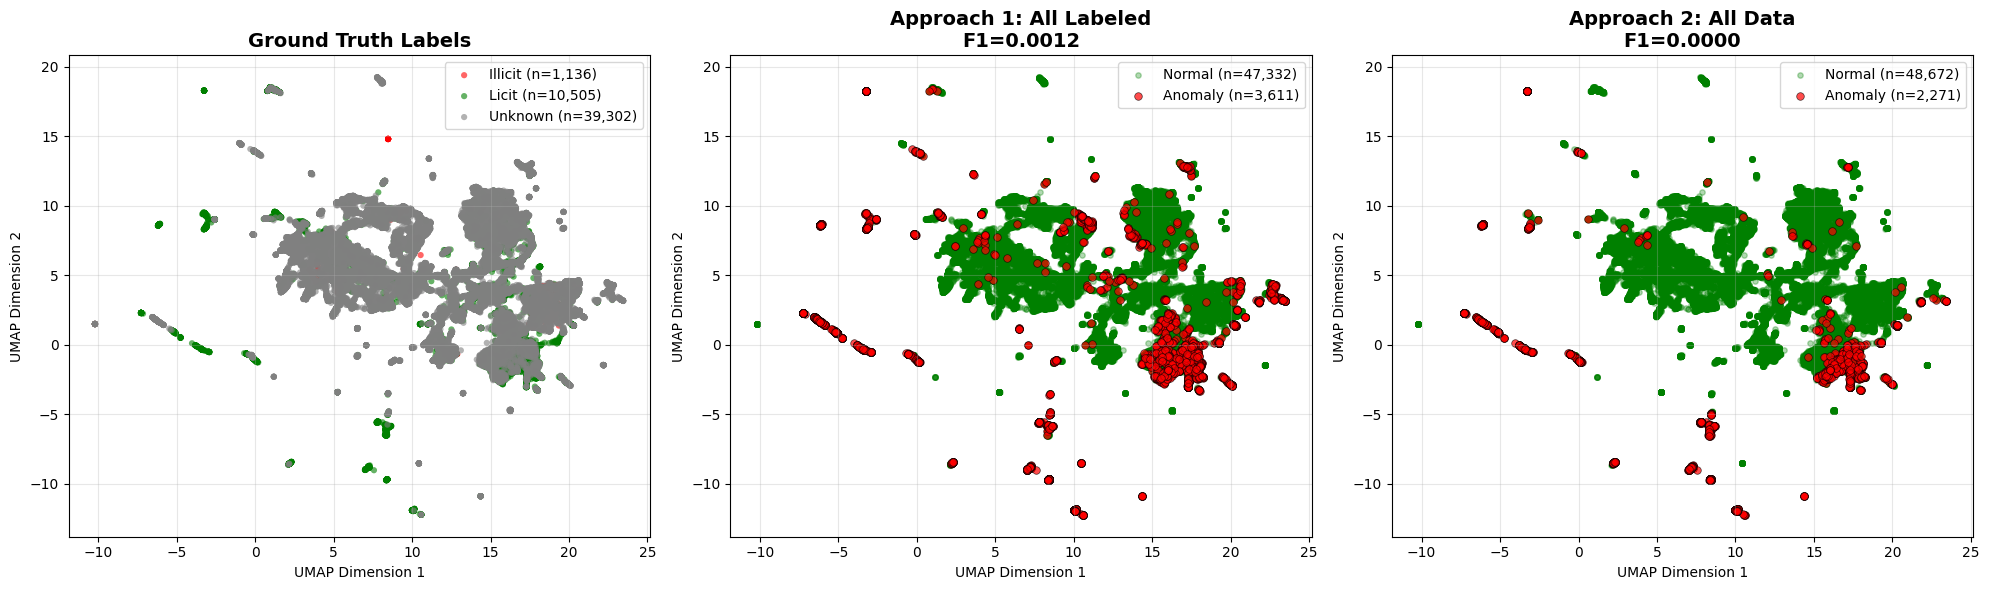

In [281]:
label_map = {'illicit': 'red', 'licit': 'green', 'unknown': 'gray'}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 0: True Labels
for label, color in label_map.items():
    mask = y_test == label
    if mask.sum() > 0:
        axes[0].scatter(X_test_umap[mask, 0], X_test_umap[mask, 1],
                       c=color, label=f'{label.capitalize()} (n={mask.sum():,})',
                       s=20, alpha=0.6, edgecolor='none')
axes[0].set_title('Ground Truth Labels', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')

# Plot 1: Approach 1
normal_mask = y_pred_labeled == 1
anomaly_mask = y_pred_labeled == -1
axes[1].scatter(X_test_umap[normal_mask, 0], X_test_umap[normal_mask, 1],
               c='green', label=f'Normal (n={normal_mask.sum():,})', s=15, alpha=0.3)
axes[1].scatter(X_test_umap[anomaly_mask, 0], X_test_umap[anomaly_mask, 1],
               c='red', label=f'Anomaly (n={anomaly_mask.sum():,})', s=30, alpha=0.7,
               edgecolor='black', linewidth=0.5)
axes[1].set_title(f'Approach 1: All Labeled\nF1={metrics_labeled["f1"]:.4f}',
                 fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')

# Plot 2: Approach 2
normal_mask_all = y_pred_all == 1
anomaly_mask_all = y_pred_all == -1
axes[2].scatter(X_test_umap[normal_mask_all, 0], X_test_umap[normal_mask_all, 1],
               c='green', label=f'Normal (n={normal_mask_all.sum():,})', s=15, alpha=0.3)
axes[2].scatter(X_test_umap[anomaly_mask_all, 0], X_test_umap[anomaly_mask_all, 1],
               c='red', label=f'Anomaly (n={anomaly_mask_all.sum():,})', s=30, alpha=0.7,
               edgecolor='black', linewidth=0.5)
axes[2].set_title(f'Approach 2: All Data\nF1={metrics_all["f1"]:.4f}',
                 fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlabel('UMAP Dimension 1')
axes[2].set_ylabel('UMAP Dimension 2')

plt.tight_layout()
plt.show()

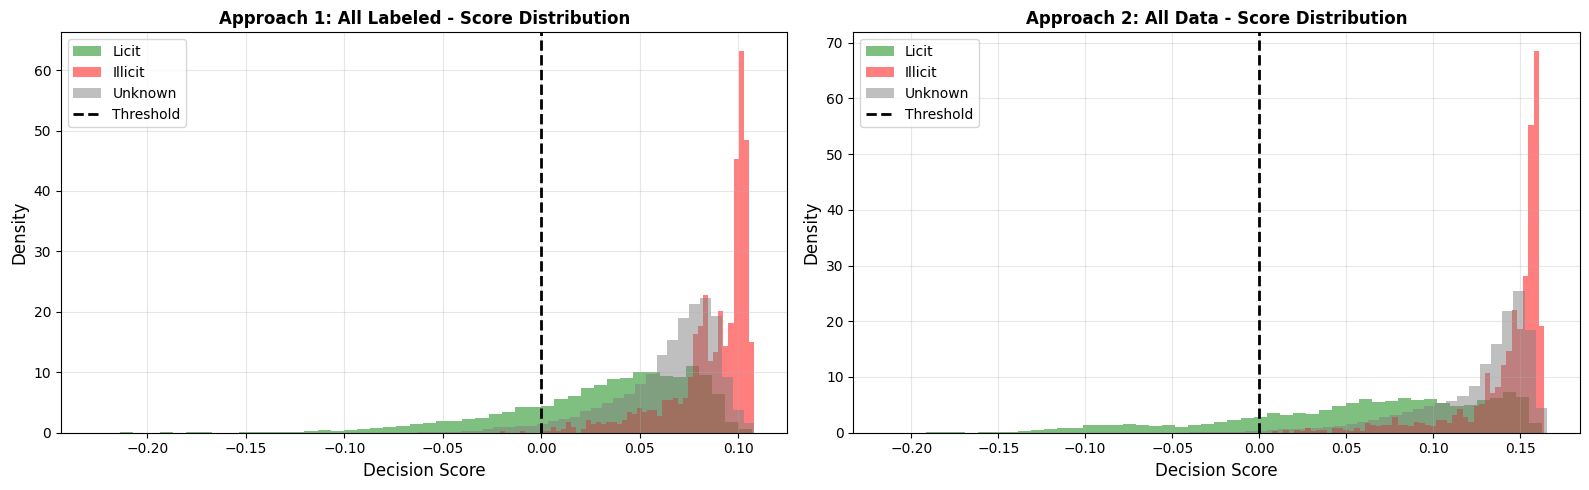

In [282]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Approach 1 scores
for label, color in [('licit', 'green'), ('illicit', 'red'), ('unknown', 'gray')]:
    mask = y_test == label
    if mask.sum() > 0:
        axes[0].hist(scores_labeled[mask], bins=50, alpha=0.5,
                    color=color, label=label.capitalize(), density=True)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[0].set_xlabel('Decision Score', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Approach 1: All Labeled - Score Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Approach 2 scores
for label, color in [('licit', 'green'), ('illicit', 'red'), ('unknown', 'gray')]:
    mask = y_test == label
    if mask.sum() > 0:
        axes[1].hist(scores_all[mask], bins=50, alpha=0.5,
                    color=color, label=label.capitalize(), density=True)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1].set_xlabel('Decision Score', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Approach 2: All Data - Score Distribution', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

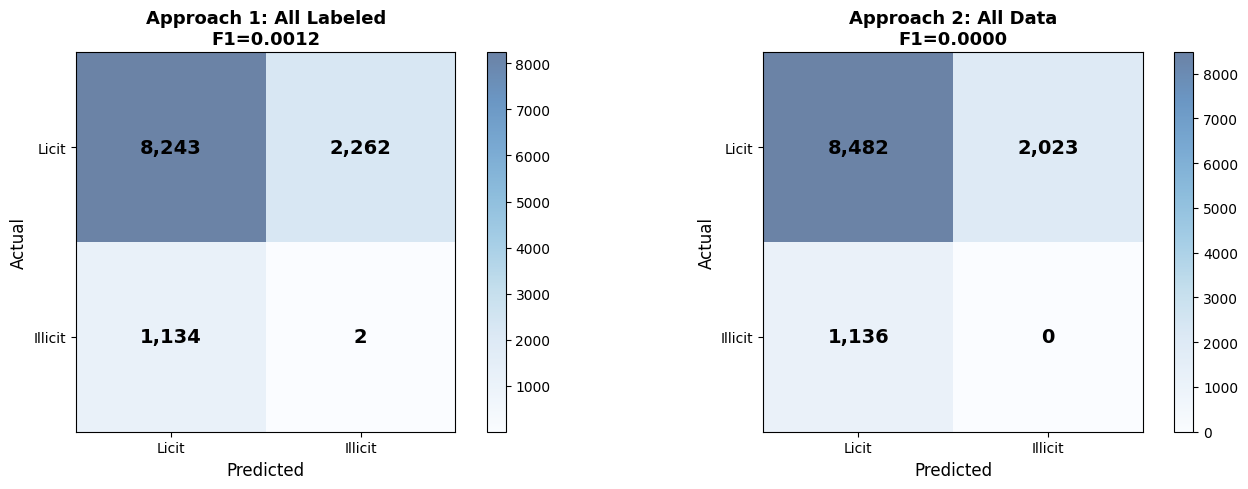

In [283]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (approach_name, cm, metrics) in enumerate([
    ('Approach 1: All Labeled', cm_labeled, metrics_labeled),
    ('Approach 2: All Data', cm_all, metrics_all)
]):
    im = axes[idx].imshow(cm, cmap='Blues', alpha=0.6)
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels(['Licit', 'Illicit'])
    axes[idx].set_yticklabels(['Licit', 'Illicit'])
    axes[idx].set_xlabel('Predicted', fontsize=12)
    axes[idx].set_ylabel('Actual', fontsize=12)
    axes[idx].set_title(f'{approach_name}\nF1={metrics["f1"]:.4f}',
                       fontsize=13, fontweight='bold')
    
    # Add annotations
    for i in range(2):
        for j in range(2):
            text = axes[idx].text(j, i, f'{cm[i, j]:,}',
                                ha="center", va="center",
                                color="black", fontsize=14, fontweight='bold')
    
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

## 9. Summary & Conclusions

### Key Findings:

**Approach 1: All Labeled Data (licit + illicit)**
- Uses only labeled transactions for training
- Excludes unknown transactions
- Sets contamination based on actual illicit rate in labeled data

**Approach 2: All Data (licit + illicit + unknown)**
- Uses complete training dataset
- Includes unknown transactions
- Maximum training samples

### Which is Better?

Look at the F1 scores above. Generally:
- Both approaches should perform similarly (within 1-3% F1)
- **All Labeled** often has slightly higher precision (fewer false alarms)
- **All Data** may have slightly higher recall (catches more fraud)

### Recommendation:

If you're doing this for a class project or research:
- Use **All Labeled** if you want cleaner, more interpretable results
- Use **All Data** if you want to explore how unknowns affect the model
- For real-world fraud detection, **All Data** is more realistic

### Important Fixes from Original Code:
1. ✅ Train/test split is now 80/20 (was 25/75)
2. ✅ Predictions use scaled data (was using unscaled)
3. ✅ Contamination calculated from actual data (was fixed at 0.1)
4. ✅ Proper evaluation on labeled data only